In [39]:
import os 
import sys
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler


In [40]:
df1 = pd.read_csv('/Users/zed/AI_Lab/DoubleEnsembleML/Data/BTC.csv')

In [41]:
df1 = df1.fillna(method='backfill')

In [42]:
df1 

,Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,1.315147e+04,841.835522
1,2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,1.609733e+04,839.156269
2,2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6.784250e+03,831.572913
3,2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6.780220e+03,844.938794
4,2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,1.669857e+04,890.671709
...,...,...,...,...,...,...,...,...
2652,2021-04-21,56500.00000,56805.50000,53600.00000,53815.20000,4788.013532,2.645352e+08,55249.477244
2653,2021-04-22,53815.30000,55459.40000,50500.00000,51730.00000,10144.204074,5.396125e+08,53194.167081
2654,2021-04-23,51709.30000,52124.40000,47549.30000,51178.70000,11159.243380,5.545896e+08,49697.773594
2655,2021-04-24,51178.60000,51200.00000,48746.40000,50093.40000,4039.459093,2.021033e+08,50032.268888


In [43]:
df1['r_0'] = df1.Close/df1.Close.shift(1)-1

In [44]:
def getDailyVol(close,span0 = 100):
    # df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    # df0 = df0[df0>0]
    # df0 = pd.Series(close.index[df0-1],index = close.index[close.shape[0]-df0.shape[0]])
    df0 = close/close.shift(1)-1
    df0 = df0.ewm(span = span0).std()
    return df0

In [45]:
dailyVol = getDailyVol(df1.Close)

In [46]:
df1['tag'] = pd.Series(map(lambda x,y: 1 if x>0.2*y else(-1 if x<-0.2*y else 0),df1.r_0,dailyVol))

In [47]:
df2 =df1.loc[:,['Date','High','Low','Close','Volume (BTC)','tag']].rename(columns = {'Volume (BTC)':'Volume'})

In [48]:
df2

,Date,High,Low,Close,Volume,tag
0,2014-01-07,892.06753,810.00000,810.00000,15.622378,0
1,2014-01-08,899.84281,788.00000,824.98287,19.182756,0
2,2014-01-09,870.00000,807.42084,841.86934,8.158335,1
3,2014-01-10,857.34056,817.00000,857.33056,8.024510,1
4,2014-01-11,918.05471,857.16554,899.84105,18.748285,1
...,...,...,...,...,...,...
2652,2021-04-21,56805.50000,53600.00000,53815.20000,4788.013532,-1
2653,2021-04-22,55459.40000,50500.00000,51730.00000,10144.204074,-1
2654,2021-04-23,52124.40000,47549.30000,51178.70000,11159.243380,-1
2655,2021-04-24,51200.00000,48746.40000,50093.40000,4039.459093,-1


In [49]:
dataset = df2 

In [50]:
dataset['Open'] = dataset['Close'].shift(1)
dataset['H-L'] = dataset['High'] - dataset['Low']
# dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['CCI'] = talib.AROONOSC(dataset.High, dataset.Low, timeperiod=14)
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)
dataset['ATR'] = talib.ATR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)
dataset['OBV'] = talib.OBV(dataset.Close, dataset.Volume)
dataset['HT_DCPERIOD'] = talib.HT_DCPERIOD(dataset.Close)

In [51]:
y = dataset['tag']
dataset = dataset.drop(['tag'],axis=1)


In [52]:
dataset

,Date,High,Low,Close,Volume,Open,H-L,3day MA,10day MA,30day MA,CCI,RSI,ATR,OBV,HT_DCPERIOD
0,2014-01-07,892.06753,810.00000,810.00000,15.622378,NaN,82.06753,NaN,NaN,NaN,NaN,NaN,NaN,15.622378,NaN
1,2014-01-08,899.84281,788.00000,824.98287,19.182756,810.00000,111.84281,NaN,NaN,NaN,NaN,NaN,NaN,34.805134,NaN
2,2014-01-09,870.00000,807.42084,841.86934,8.158335,824.98287,62.57916,NaN,NaN,NaN,NaN,NaN,NaN,42.963468,NaN
3,2014-01-10,857.34056,817.00000,857.33056,8.024510,841.86934,40.34056,825.617403,NaN,NaN,NaN,NaN,NaN,50.987979,NaN
4,2014-01-11,918.05471,857.16554,899.84105,18.748285,857.33056,60.88917,841.394257,NaN,NaN,NaN,NaN,NaN,69.736264,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652,2021-04-21,56805.50000,53600.00000,53815.20000,4788.013532,56500.00000,3205.50000,56153.266667,59957.89,57851.923333,-28.571429,31.587568,3594.414995,606743.431869,15.992169
2653,2021-04-22,55459.40000,50500.00000,51730.00000,10144.204074,53815.20000,4959.40000,55345.066667,59343.81,57842.593333,-57.142857,26.873534,3789.412853,596599.227795,15.760320
2654,2021-04-23,52124.40000,47549.30000,51178.70000,11159.243380,51730.00000,4575.10000,54015.066667,58534.44,57755.216667,-64.285714,25.731360,3901.653874,585439.984415,15.631061
2655,2021-04-24,51200.00000,48746.40000,50093.40000,4039.459093,51178.70000,2453.60000,52241.300000,57293.59,57718.046667,-64.285714,23.517675,3694.789035,581400.525322,15.618939


In [53]:
dataset.Close.shift(1)

0               NaN
1         810.00000
2         824.98287
3         841.86934
4         857.33056
           ...     
2652    56500.00000
2653    53815.20000
2654    51730.00000
2655    51178.70000
2656    50093.40000
Name: Close, Length: 2657, dtype: float64

In [54]:
for i in range(1,6):
    name = 'Last'+str(i)+'Price'
    dataset[name] = dataset.Close.shift(i)

In [55]:
dataset['tag'] = y 

In [56]:
dataset = dataset.dropna(how = 'any')

In [57]:
dataset.to_csv('mybtc.csv')

In [58]:
dataset 

,Date,High,Low,Close,Volume,Open,H-L,3day MA,10day MA,30day MA,...,RSI,ATR,OBV,HT_DCPERIOD,Last1Price,Last2Price,Last3Price,Last4Price,Last5Price,tag
32,2014-02-08,730.0000,680.01000,699.30255,31.042254,714.12206,49.99000,761.410300,796.146558,819.809884,...,22.702711,40.886460,-168.377924,15.646696,714.12206,767.60884,802.50000,802.40000,819.78000,-1
33,2014-02-09,756.0998,684.85098,689.00000,38.291274,699.30255,71.24882,727.011150,786.576813,815.057658,...,21.318570,45.223940,-206.669198,17.190252,699.30255,714.12206,767.60884,802.50000,802.40000,-1
34,2014-02-10,748.0000,550.00000,690.20000,29.856668,689.00000,198.00000,700.808203,774.676813,809.446639,...,21.942173,67.049091,-176.812530,18.731589,689.00000,699.30255,714.12206,767.60884,802.50000,0
35,2014-02-11,720.0000,660.00000,714.56111,33.331274,690.20000,60.00000,692.834183,762.477776,802.458604,...,33.905912,66.042078,-143.481256,20.302886,690.20000,689.00000,699.30255,714.12206,767.60884,1
36,2014-02-12,709.9300,651.30901,670.66590,17.641851,714.56111,58.62099,697.920370,751.433887,797.610641,...,25.868810,65.643510,-161.123107,21.888230,714.56111,690.20000,689.00000,699.30255,714.12206,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652,2021-04-21,56805.5000,53600.00000,53815.20000,4788.013532,56500.00000,3205.50000,56153.266667,59957.890000,57851.923333,...,31.587568,3594.414995,606743.431869,15.992169,56500.00000,55720.00000,56239.80000,60085.20000,61455.00000,-1
2653,2021-04-22,55459.4000,50500.00000,51730.00000,10144.204074,53815.20000,4959.40000,55345.066667,59343.810000,57842.593333,...,26.873534,3789.412853,596599.227795,15.760320,53815.20000,56500.00000,55720.00000,56239.80000,60085.20000,-1
2654,2021-04-23,52124.4000,47549.30000,51178.70000,11159.243380,51730.00000,4575.10000,54015.066667,58534.440000,57755.216667,...,25.731360,3901.653874,585439.984415,15.631061,51730.00000,53815.20000,56500.00000,55720.00000,56239.80000,-1
2655,2021-04-24,51200.0000,48746.40000,50093.40000,4039.459093,51178.70000,2453.60000,52241.300000,57293.590000,57718.046667,...,23.517675,3694.789035,581400.525322,15.618939,51178.70000,51730.00000,53815.20000,56500.00000,55720.00000,-1


In [59]:
r = dataset.Close/dataset.Close.shift(1)-1

In [60]:
r.dropna(how = "any")

33     -0.014733
34      0.001742
35      0.035296
36     -0.061430
37     -0.069662
          ...   
2652   -0.047519
2653   -0.038747
2654   -0.010657
2655   -0.021206
2656   -0.028267
Name: Close, Length: 2586, dtype: float64

In [61]:
plt.style.use('ggplot')

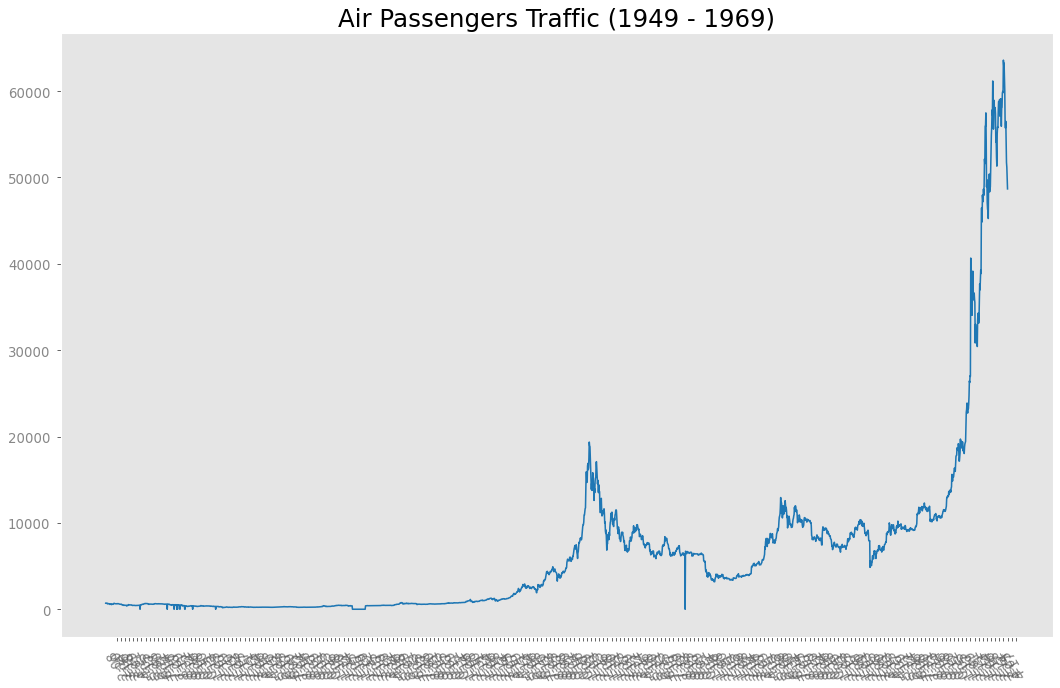

In [62]:

# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.style.use('seaborn-paper')
plt.plot('Date', 'Close', data = dataset, color='tab:blue')

# Decoration

xtick_location = dataset.index.tolist()[::12]
xtick_labels = [x[-4:30:] for x in dataset.Date.tolist()[::12]]

plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=120, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Air Passengers Traffic (1949 - 1969)", fontsize=22)
plt.grid(axis='both', alpha=.3)

# Remove borders
# plt.gca().spines["top"].set_alpha(0.0)    
# plt.gca().spines["bottom"].set_alpha(0.3)
# plt.gca().spines["right"].set_alpha(0.0)    
# plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

In [63]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']